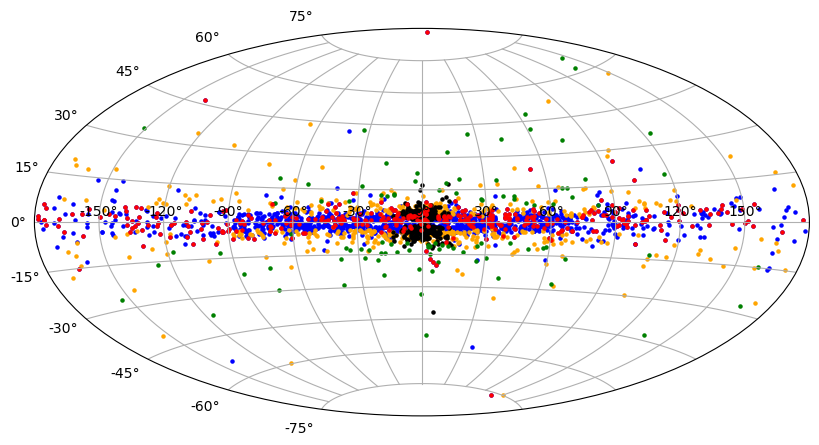

Thin Disc: 1581
Thick Disk: 475
Bulge: 437
Halo: 98
no distance: 359


In [3]:
import pandas as pd
from openpyxl import load_workbook
from openpyxl.styles import PatternFill
from openpyxl.utils.dataframe import dataframe_to_rows
import numpy as np
import matplotlib.pyplot as plt

# Excel dosyasını yükle
file_path = '/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/sigma_5/bilgiislem/8.34/6563/6563.xlsx'
sheet_name = 'Sayfa2'
new_sheet_name = 'Sayfa3'

# Excel dosyasını oku
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Galactic_RA, Galactic_DEC, Disc_R ve rgeo sütunlarını al
galactic_ra = df['Glon']
galactic_dec = df['Glat']
disc_r = df['Gdist']  # Galaktik merkezden uzaklık sütunu (parsek cinsinden)
rgeo = df['rgeo']  # Kaynakların bizden uzaklıkları (parsek cinsinden)

# Galaktik koordinatları al
l = galactic_ra
b = galactic_dec

# Galaksi merkezini aitoff projeksiyonu üzerinde 0 dereceye 0 derecede konumlandırmak için
l_centered = (l - 180) % 360 - 180  # -180 ile 180 derece arasında merkezlenmiş boylam

# Harita oluştur
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection='aitoff')
ax.grid(True)

# İnce disk ve kalın disk kriterleri (galaktik yükseklik z'de)
z_ince_disk_max = 400  # parsek
z_kalin_disk_max = 1000  # parsek

ince_disk_bolge = np.abs(disc_r) <= z_ince_disk_max
kalin_disk_bolge = (np.abs(disc_r) > z_ince_disk_max) & (np.abs(disc_r) <= z_kalin_disk_max)

# İnce disk bölgesini işaretle
ax.scatter(np.radians(l_centered[ince_disk_bolge]), np.radians(b[ince_disk_bolge]), color='blue', s=5)#, label='Thin Disc')

# Kalın disk bölgesini işaretle
ax.scatter(np.radians(l_centered[kalin_disk_bolge]), np.radians(b[kalin_disk_bolge]), color='orange', s=5)#, label='Thick Disc')

# Galaksi merkezi ve şişkin bölge tanımı
galactic_center_distance_from_us = 8340  # parsek
galactic_bulge_radius = 2000  # parsek

# Şişkin bölge kriteri: Galaksi merkezi etrafında 2 kpc yarıçapında bir küre
siskin_bolge_bolge = (rgeo >= (galactic_center_distance_from_us - galactic_bulge_radius)) & (rgeo <= (galactic_center_distance_from_us + galactic_bulge_radius))

# Glon değeri 14 ile 346 arasında olanları şişkin bölgeden çıkartma
siskin_bolge_bolge = siskin_bolge_bolge & ~((galactic_ra > 14) & (galactic_ra < 346))

# Şişkin bölge içinde olan noktaları mavi renkte çiz
ax.scatter(np.radians(l_centered[siskin_bolge_bolge]), np.radians(b[siskin_bolge_bolge]), color='black', s=5)#, label='Galactic Bulge')

# Halo bölgesi
halo_bolge = ~(ince_disk_bolge | kalin_disk_bolge | siskin_bolge_bolge)
ax.scatter(np.radians(l_centered[halo_bolge]), np.radians(b[halo_bolge]), color='green', s=5)#, label='Halo')

# Diskten uzaklığı 0 olan noktaları gri renkte çiz
ax.scatter(np.radians(l_centered[np.isclose(disc_r, 0)]), np.radians(b[np.isclose(disc_r, 0)]), color='red', s=5 )#, label='No Distance')

# Eksenleri ve başlığı ekle
#ax.set_title('Galactic Coordinate Map')
#ax.set_xlabel('Galactic Longitude (l) [degree]')
#ax.set_ylabel('Galactic Latitude (b) [degree]')

# PNG dosyasını kaydet
plt.savefig('/Users/nurullah/Desktop/galaxy_abudance/Uzak_Pc/TJAA/Aitof_projectt.png')
plt.show()
plt.close()

# Excel dosyasını yükle
wb = load_workbook(file_path)

# Yeni sayfa oluştur
if new_sheet_name in wb.sheetnames:
    ws = wb[new_sheet_name]
else:
    ws = wb.create_sheet(new_sheet_name)

# Gbileşen sütununu oluştur ve verileri güncelle
df['Gbileşen'] = ''
for idx in df.index:
    #if np.isclose(disc_r[idx], 0):
        #df.at[idx, 'Gbileşen'] = 'no distance'
    if siskin_bolge_bolge[idx]:
        df.at[idx, 'Gbileşen'] = 'Bulge'
    elif ince_disk_bolge[idx]:
        df.at[idx, 'Gbileşen'] = 'Thin Disc'
    elif kalin_disk_bolge[idx]:
        df.at[idx, 'Gbileşen'] = 'Thick Disk'
    else:
        df.at[idx, 'Gbileşen'] = 'Halo'

# Güncellenen verileri yeni sayfaya yaz
for r in dataframe_to_rows(df, index=False, header=True):
    ws.append(r)

# Şişkin bölgeye denk gelen satırları belirle
for idx in df.index:
    row_num = idx + 2
    gbilesen = df.at[idx, 'Gbileşen']
    
    #if gbilesen == 'no distance':
        #fill = PatternFill(start_color='C0C0C0', end_color='C0C0C0', fill_type='solid')  # Gri
    if gbilesen == 'Thin Disc':
        fill = PatternFill(start_color='FF0000', end_color='FF0000', fill_type='solid')  # Kırmızı
    elif gbilesen == 'Thick Disk':
        fill = PatternFill(start_color='00FF00', end_color='00FF00', fill_type='solid')  # Yeşil
    elif gbilesen == 'Bulge':
        fill = PatternFill(start_color='0000FF', end_color='0000FF', fill_type='solid')  # Mavi
    elif gbilesen == 'Halo':
        fill = PatternFill(start_color='FFA500', end_color='FFA500', fill_type='solid')  # Turuncu
    else:
        fill = None
    
    # Renklendirme işlemini ilgili hücrelere uygula
    if fill:
        for col in range(1, len(df.columns) + 1):
            ws.cell(row=row_num, column=col).fill = fill

# Değişiklikleri kaydet
wb.save(file_path)

# Gbileşen sütunundaki her bir kategorinin sayısını hesapla
gbilesen_counts = df['Gbileşen'].value_counts()

# Gbileşen sütunundaki verilerin sayısını ekrana yazdır
for gbilesen, count in gbilesen_counts.items():
    print(f"{gbilesen}: {count}")

# no distance veri sayısını ekrana yazdır
no_distance_count = (df['Gdist'] == 0).sum()
print(f"no distance: {no_distance_count}")